In [ ]:
# Install all necessary libraries
!pip install pandas_datareader
!pip install yfinance
!pip install fix_yahoo_finance

In [ ]:
# Import Dependencies
from numpy.core.fromnumeric import mean
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
from pandas_datareader import data as pdr
import yfinance as yfin
yfin.pdr_override()
import seaborn as sns
from scipy import stats
import statsmodels.api as sm

In [ ]:
securities = pd.read_csv("FuturesList.csv")
securities

,ASSET CLASS,TICKER,ETF_FULL NAME
0,Equities,SPY,SPDR S&P 500 ETF Trust
1,Derivatives & Commodities,GC=F,Gold Dec 23
2,Derivatives & Commodities,ZC=F,"Corn Futures,Dec-2023"
3,Derivatives & Commodities,ZS=F,Soybean Futures
4,Derivatives & Commodities,HG=F,Copper Sep 23


In [ ]:
# Import the list of stock of portfolio and their weights
FuturesList = pd.read_csv("FuturesList.csv")
FuturesList=FuturesList['TICKER']
FuturesList

0     SPY
1    GC=F
2    ZC=F
3    ZS=F
4    HG=F
Name: TICKER, dtype: object

In [ ]:
# Define Functions
def get_weekly_data(stocks, start, end):
    # Convert stocks series to list
    stocks_list = stocks.tolist()

    # Get daily stock data
    stockData = pdr.get_data_yahoo(stocks_list, start, end)

    # Resample to weekly closing prices
    weekly_stockData = stockData['Close'].resample('W-FRI').last()

    return weekly_stockData

# Compute Box-Cos transformation of data (in this case the log transform)
def compute_log_returns(df):
    log_returns = pd.DataFrame(index=df.index[1:])
    for col in df.columns:
        log_returns[col] = np.log(df[col] / df[col].shift(1))[1:]
    return log_returns

    return log_returns

def plot_qq_and_shapiro_test(df):
    num_cols = df.shape[1]

    # Determine number of rows and columns for subplots based on total columns
    nrows = int(np.ceil(np.sqrt(num_cols)))
    ncols = int(np.ceil(num_cols / nrows))

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5 * ncols, 4 * nrows))

    # Flatten axes if there's only one row
    if nrows == 1:
        axes = axes.reshape(-1, ncols)

    for idx, col in enumerate(df.columns):
        ax = axes[idx // ncols, idx % ncols]

        sm.qqplot(df[col], line='s', ax=ax)
        ax.set_title(col)
        print(f"Shapiro Test for {col}:", stats.shapiro(df[col]))

    # Hide any unused subplots
    for idx in range(num_cols, nrows * ncols):
        axes[idx // ncols, idx % ncols].axis('off')

    plt.tight_layout()
    plt.show()

def plot_t_plots(df):
    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 15))

    for idx, col in enumerate(df.columns):
        for df_value in [4]:
            stats.probplot(df[col], dist=stats.t(df_value), plot=axes[int(idx / 2), idx % 2])
            axes[int(idx / 2), idx % 2].set_title(f"{col} df = {df_value}")

    plt.tight_layout()
    plt.show()

from scipy.stats import t, norm


def plot_kdes(log_returns, degrees_of_freedom=5):
    # Define the x range
    x = np.linspace(-0.1, 0.1, 1000)

    # Number of columns in the log returns DataFrame
    num_cols = log_returns.shape[1]

    # Set up subplots
    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 12))
    for idx, col in enumerate(log_returns.columns):
        ax = axes[idx // 2, idx % 2]

        # Compute the KDE
        log_return_values = log_returns[col].dropna().values
        sns.kdeplot(log_return_values, ax=ax, label='KDE')

        # MAD for t-distribution
        mad_t = np.median(np.abs(log_return_values - np.median(log_return_values))) * np.sqrt(degrees_of_freedom / (degrees_of_freedom - 2)) / t.ppf(0.75, degrees_of_freedom)

        # Plotting t and normal distributions
        ax.plot(x, t.pdf(x, degrees_of_freedom, loc=np.mean(log_return_values), scale=mad_t), 'r--', linewidth=2, label=f't: df={degrees_of_freedom}')
        ax.plot(x, norm.pdf(x, loc=np.mean(log_return_values), scale=np.std(log_return_values)), 'b-.', linewidth=2, label='Normal')

        ax.set_title(f"Variable {idx + 1}")
        ax.set_ylim(0, 30)
        ax.legend()

    # Remove any unused plots
    for idx in range(num_cols, 6):
        axes[idx // 2, idx % 2].axis('off')

    plt.tight_layout()
    plt.show()

# Example Usage
# Assuming log_returns is your DataFrame
# plot_kdes(log_returns)


In [ ]:
# Export dataframe with price data
start = '2003-01-01'
end = '2023-01-01'
df = get_weekly_data(FuturesList, start, end)

[*********************100%***********************]  5 of 5 completed


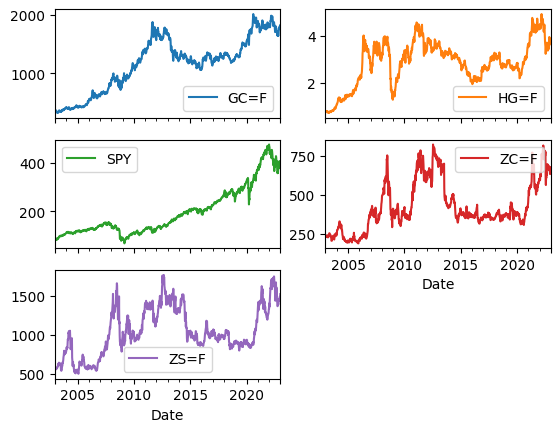

In [ ]:
df.plot(subplots=True, layout=(3,2))
plt.show()

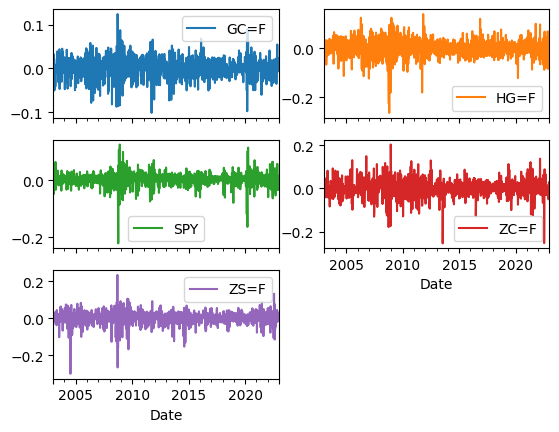

In [ ]:
# Assuming weekly_commodity_price_data is already read into memory
log_returns = compute_log_returns(df)
log_returns.plot(subplots=True, layout=(3,2))
plt.show()

Shapiro Test for GC=F: ShapiroResult(statistic=0.9773346781730652, pvalue=1.0899118413343345e-11)
Shapiro Test for HG=F: ShapiroResult(statistic=0.9563360810279846, pvalue=4.399026237768051e-17)
Shapiro Test for SPY: ShapiroResult(statistic=0.9025248289108276, pvalue=3.105217833124757e-25)
Shapiro Test for ZC=F: ShapiroResult(statistic=0.9574145674705505, pvalue=7.410619787122949e-17)
Shapiro Test for ZS=F: ShapiroResult(statistic=0.9226201772689819, pvalue=1.0235690495207366e-22)


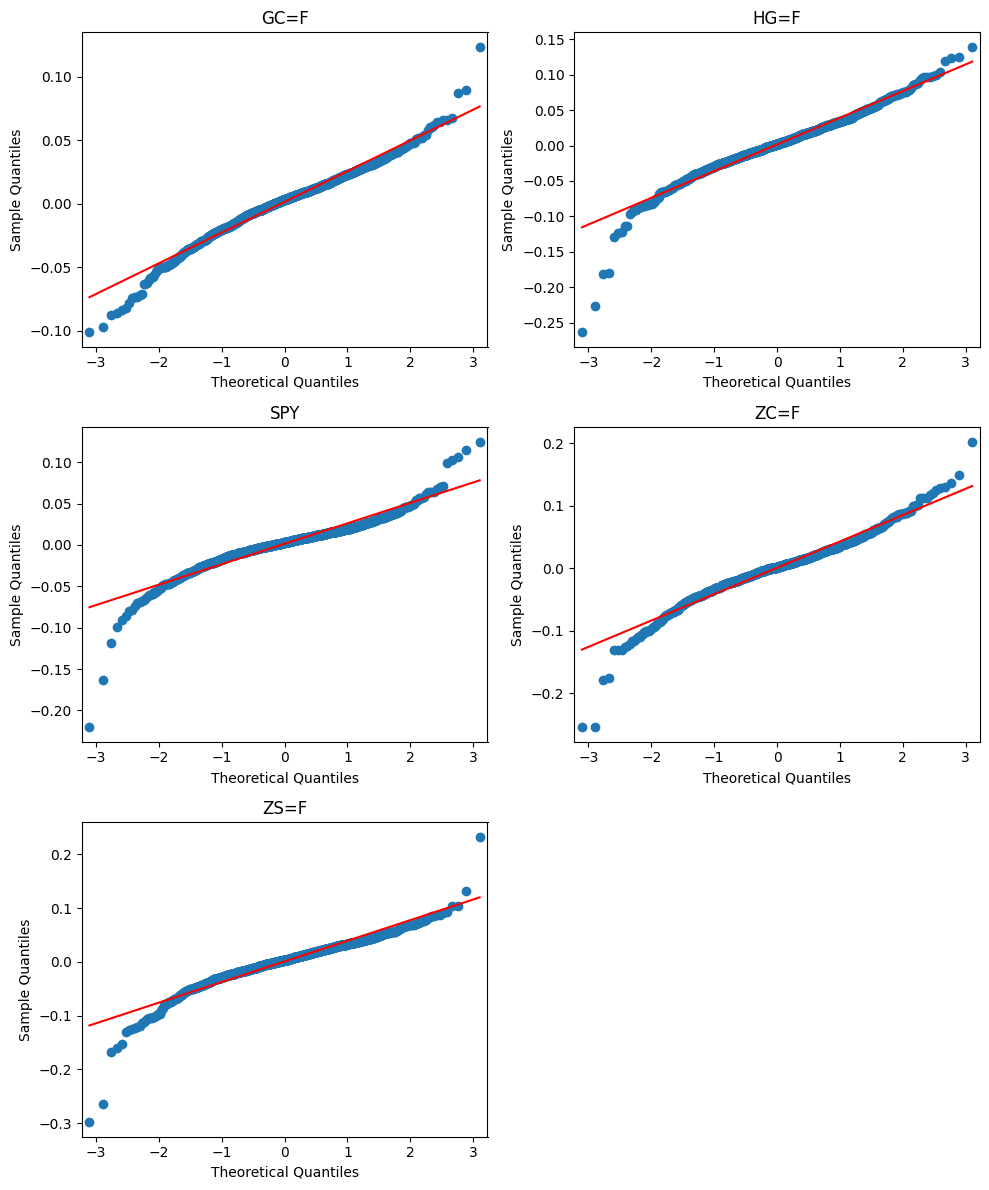

In [ ]:
# Plotting QQ plots and executing Shapiro-Wilk tests
plot_qq_and_shapiro_test(log_returns)

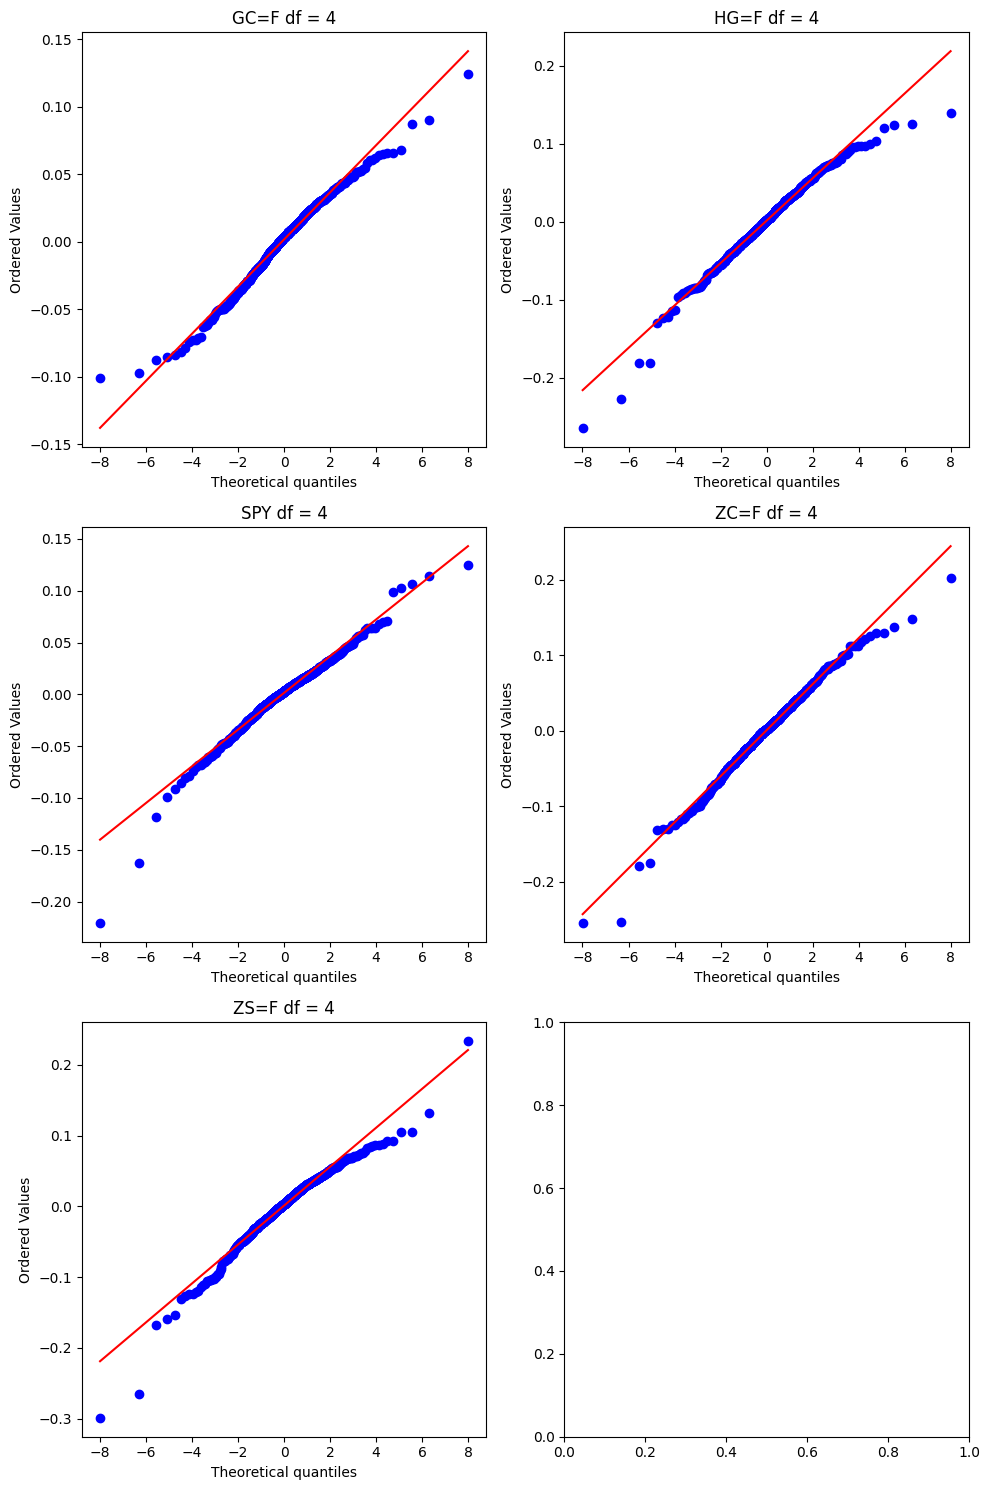

In [ ]:
# Computing and plotting t-plots
plot_t_plots(log_returns)

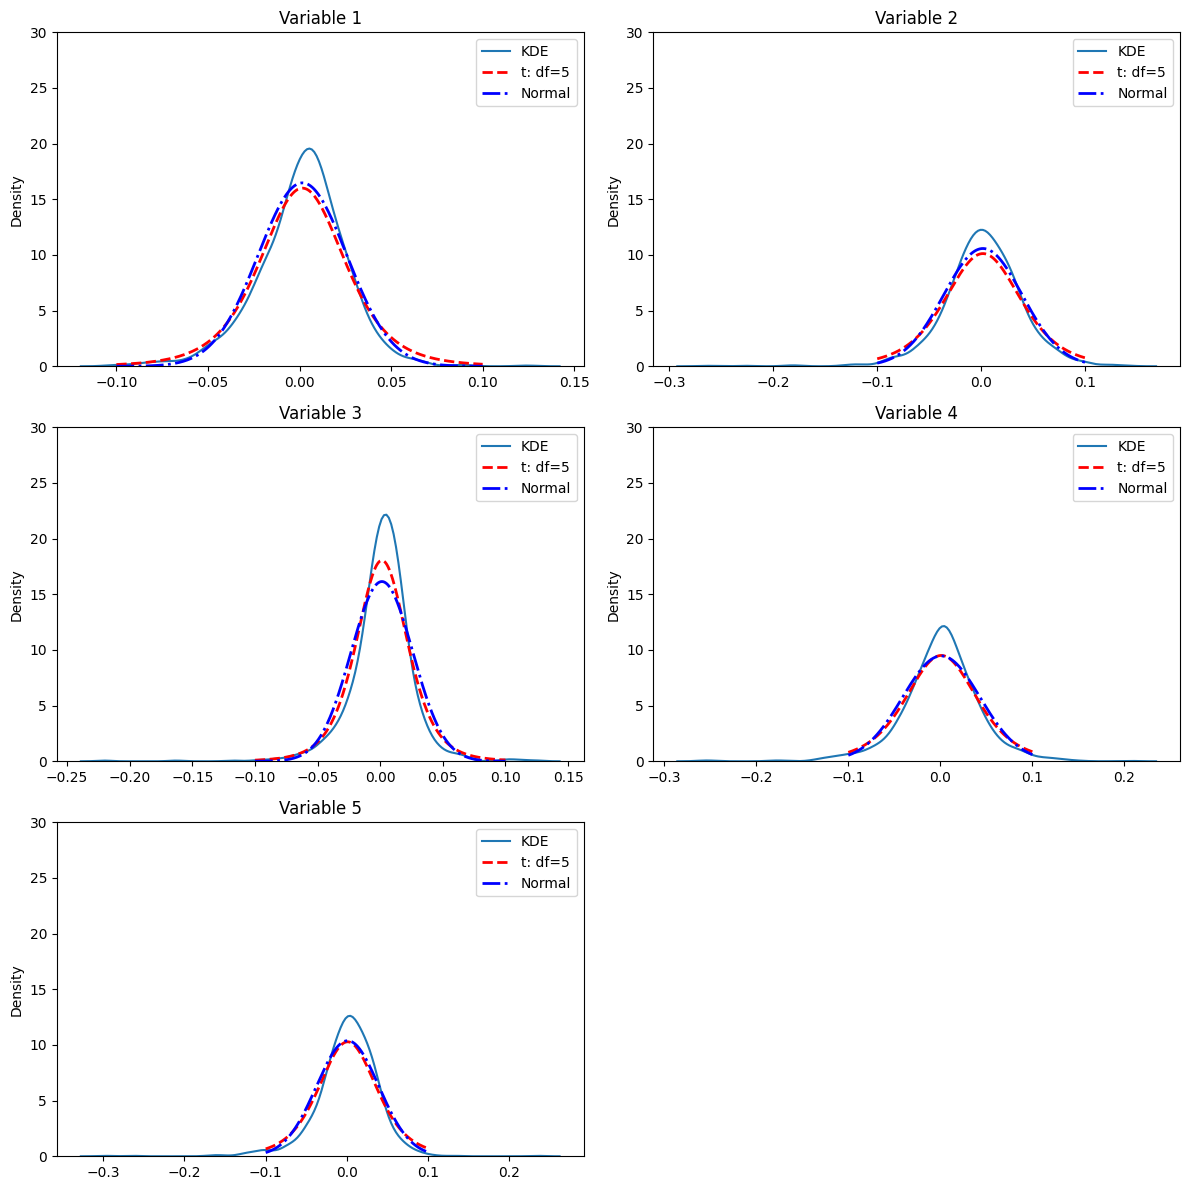

In [ ]:
# Plotting KDEs
plot_kdes(log_returns)